# Trigger Word Detection

Implementaremos mediante Pytorch una red de speech detection con el objetivo de detectar palabras disparadoras. Esta tecnología es normalmente ocupada por Amazon Alexa, Google Home, Apple Siri, y Baidu DuerOS. En este caso buscaremos que cada vez que detecte la palabra "activate" se emita un sonido.

En este proyecto ocuparemos el dataset de entrenamiento proporcionado en el curso de Sequence Models de Andrew Ng. Estos datos están conformados por 32 ejemplos de audios. Cada audio tiene una duración de 10 segundos dividido en 5.511 unidades de tiempo. Cada unidad de tiempo esta conformada por un vector que posee 101 frecuencias del espectrograma. La salida del modelo esta dividida en 1.375 unidades de tiempo. Las etiquetas se establecen en 1 durante 50 pasos de tiempo consecutivos cuando la palabra "activate" esté presente y en 0 para todos los demás pasos de tiempo.

<center>
<img src="Arquitectura.png" style="width:600px;height:600px;">
    <caption><center><font color='purple'>Trigger Word Detection Model</center></caption>
</center></font>

In [21]:
import numpy as np
from td_utils import *
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from pydub import AudioSegment
import IPython

In [22]:
X = np.load("./XY_train/X.npy")
Y = np.load("./XY_train/Y.npy")

In [23]:
X.shape, Y.shape

((32, 5511, 101), (32, 1375, 1))

In [25]:
class Dataset(Dataset):
    def __init__(self, X_train, y_train):
        self.x_data = X_train
        self.y_data = y_train
        
    def __getitem__(self, idx):
        return torch.tensor(self.x_data[idx], dtype=torch.float32), torch.tensor(self.y_data[idx], dtype=torch.float32)
    
    def __len__(self):
        return len(self.x_data)

In [26]:
batch_size = 8

dataset = Dataset(X, Y)
train_loader = DataLoader(dataset = dataset, batch_size = batch_size, shuffle = True)

In [33]:
next(iter(train_loader))[0].shape

torch.Size([8, 5511, 101])

In [63]:
class Trigger_Model(nn.Module):
    def __init__(self):
        super(Trigger_Model, self).__init__()
        # Conv Layer 1D
        self.conv = nn.Conv1d(in_channels=101, out_channels=196, kernel_size=15, stride=4)
        # La convulsión ocupa un filtro de tamaño 15 a lo largo de los 5511 pasos
        # Reduce su dimensionalidad a 1375 pasos de tiempo con vectores de 196 valores
        self.batch_norm1 = nn.BatchNorm1d(196) # 196 canales
        self.activation1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.8)
        
        # GRU Layer 1
        self.gru1 = nn.GRU(input_size=196, hidden_size=128, bidirectional=False, batch_first=True)
        # Recordar que estamos ocupando el batch como primera dimensión
        self.dropout2 = nn.Dropout(0.8)
        self.batch_norm2 = nn.BatchNorm1d(128)
        
        # GRU Layer 2
        self.gru2 = nn.GRU(input_size=128, hidden_size=128, bidirectional=False, batch_first=True)
        self.dropout3 = nn.Dropout(0.8)
        self.batch_norm3 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(0.8)
        
        # Dense Layer para cada paso de tiempo (Time-distributed)
        # En pytorch no es necesario implementar un loop para cada time-step
        self.dense = nn.Linear(128, 1) # Predicción para cada instante
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, x):
       # Conv Layer 1D
        x = x.transpose(1, 2)
        # Los canales deben estar en la segunda dimensión (batch_size, in_channels, sequence_length)
        x = self.conv(x)
        x = self.batch_norm1(x)
        x = self.activation1(x)
        x = self.dropout1(x)
        
        # GRU Layer 1
        x = x.transpose(1, 2) 
        # Traemos las dimensiones como antes (batch_size, sequence_length, input_size)
        x, _ = self.gru1(x)
        x = self.dropout2(x)
        x = x.transpose(1, 2)
        # Volvemos a la dimnesión (batch_size, in_channels, sequence_length) para aplicar normalización
        x = self.batch_norm2(x)
        x = x.transpose(1, 2)
        
        # GRU Layer 2
        x, _ = self.gru2(x)
        x = self.dropout3(x)
        x = x.transpose(1, 2)
        x = self.batch_norm3(x)
        x = x.transpose(1, 2)
        x = self.dropout4(x)
        
        # Time-distributed dense layer
        x = self.dense(x)
        output = self.sigmoid(x)
        
        return output

In [130]:
learning_rate = 0.001
num_epochs = 100

device = torch.device("cuda") if torch.cuda.is_available() else 'cpu'
model = Trigger_Model().to(device)
model

Trigger_Model(
  (conv): Conv1d(101, 196, kernel_size=(15,), stride=(4,))
  (batch_norm1): BatchNorm1d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation1): ReLU()
  (dropout1): Dropout(p=0.8, inplace=False)
  (gru1): GRU(196, 128, batch_first=True)
  (dropout2): Dropout(p=0.8, inplace=False)
  (batch_norm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gru2): GRU(128, 128, batch_first=True)
  (dropout3): Dropout(p=0.8, inplace=False)
  (batch_norm3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.8, inplace=False)
  (dense): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [65]:
criterion = nn.BCELoss() # Binary Cross Entropy
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [75]:
def accuracy(predictions, targets):
    rounded_predictions = torch.round(predictions) # Redondeamos
    targets = targets.squeeze(dim=2) # Eliminamos última dimensión targets torch.Size([8, 1375, 1]))
    correct = (rounded_predictions == targets).sum().item()
    total = targets.numel()
    acc = correct / total
    return acc

In [131]:
for epoch in range(num_epochs):
    train_accuracy = 0 # Reiniciamos accuracy a 0
    for (examples, classes) in train_loader:
        examples = examples.to(device)
        classes = classes.to(device)
        
        outputs = model(examples) 
        loss = criterion(outputs, classes)
        
        # backward
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 
        
        # accuracy
        batch_accuracy = accuracy(outputs.squeeze(), classes)
        train_accuracy += batch_accuracy
        
    train_accuracy /= len(train_loader) # total accuracy
    
    if (epoch + 1) % 10 == 0:
        print(f'epoch {epoch + 1}/{num_epochs}, accuracy={train_accuracy:.4f}')
        
print(f'final accuracy, accuracy = {train_accuracy:.4f}')

epoch 10/100, accuracy=0.5087
epoch 20/100, accuracy=0.5056
epoch 30/100, accuracy=0.5062
epoch 40/100, accuracy=0.5050
epoch 50/100, accuracy=0.5060
epoch 60/100, accuracy=0.5101
epoch 70/100, accuracy=0.5059
epoch 80/100, accuracy=0.5106
epoch 90/100, accuracy=0.5124
epoch 100/100, accuracy=0.5073
final accuracy, accuracy = 0.5073


El modelo actual muestra una precisión baja debido a las limitaciones del entrenamiento realizado en este proyecto de prueba. El entrenamiento se llevó a cabo utilizando un número reducido de ejemplos y solo 100 epochs en una CPU. Es importante destacar que el modelo original fue entrenado en Keras, lo que dificulta realizar un fine-tune o ajuste fino para mejorar su desempeño debido a posibles incompatibilidades y restricciones en la arquitectura y estructura del modelo.

## Predicción

In [132]:
def detect_triggerword(filename):
    audio_clip = AudioSegment.from_wav(filename)
    audio_clip = match_target_amplitude(audio_clip, -20.0) # Estandarizar volumen
    file_handle = audio_clip.export("tmp.wav", format="wav") # Exportamos audio estandarizado
    filename = "tmp.wav"

    # Necesitamos que la entrada del modelo sea (batch_size, sequence_length, in_channels)
    # El cambio de dimensiones está en el forward para hacer las convulsiones
    x = graph_spectrogram(filename) # Retorna una matriz 101, 5511 y espectrograma
    x  = x.swapaxes(0,1) # Cambio dimensiones a 5511, 101 => Tx, frecuencias
    x = np.expand_dims(x, axis=0) # Dimensión adicional del batch
    x = torch.tensor(x, dtype=torch.float32)
    predictions = model(x) # Predicción, reduzco dimensionalidad
    predictions = predictions.detach().numpy()
    return predictions

(1, 1375, 1)

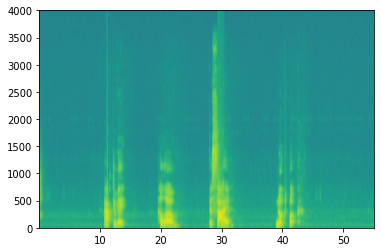

In [133]:
filename = "./raw_data/dev/1.wav"
predictions = detect_triggerword(filename)
predictions.shape # Segunda dimensión tiene los time-stamps

In [134]:
chime_file = "audio_examples/chime.wav" # Chime sonido
def chime_on_activate(filename, predictions, threshold):
    audio_clip = AudioSegment.from_wav(filename)
    chime = AudioSegment.from_wav(chime_file)
    Ty = predictions.shape[1] # Número Time Stemps salida, es decir, 1375
    # Time Stemps
    consecutive_timesteps = 0
    i = 0
    # Iteramos para cada time stemp de la salida
    while i < Ty:
        # Incrementamos valor
        consecutive_timesteps += 1
        # Si el contador de timesteps consecutivos supera un valor predefinido (20 en este caso), se inserta el sonido de campana (chime) 
        if consecutive_timesteps > 20:
            # Superponemos clip de audio y chime ocupando pydub
            audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio_clip.duration_seconds) * 1000)
            consecutive_timesteps = 0
            i = 75 * (i // 75 + 1)
            # Para evitar insertar múltiples chimes muy cercanos en el tiempo, se limita la inserción del chime a una vez cada 75 timesteps consecutivos
            continue
        # Si para ese time stemp, la predicción no supera el treshold, consecutive_timestemps vuelve a 0
        # Si la probabilidad supera el umbral, se inicia (consecutive_timesteps) que cuenta la cantidad de timesteps consecutivos con probabilidad alta
        if predictions[0, i, 0] < threshold:
            consecutive_timesteps = 0
        i += 1
        
    audio_clip.export("chime_output.wav", format='wav') # Si no detecta, el sonido suena al final

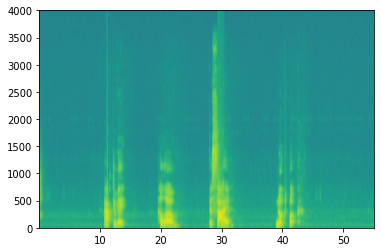

In [135]:
filename = "./raw_data/dev/1.wav"
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.5)
IPython.display.Audio("./chime_output.wav")